In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

from buddi_data import BuDDIData

2025-04-15 15:39:15.819346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 15:39:15.829229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744753155.839474  209441 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744753155.842736  209441 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744753155.851511  209441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_HGSC']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.insert(0, str(buddi_fork_path))
from buddi.models.buddi4 import build_buddi4
from buddi.models.components.layers import ReparameterizationLayer

I0000 00:00:1744753157.263548  209441 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5744 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


### Validation Output plot path

In [5]:
VALIDATION_OUTPUT = pathlib.Path('.').absolute() / 'validation_output'
VALIDATION_OUTPUT.mkdir(exist_ok=True)

### Train model weight and data

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained_models'
TRAIN_DATA_FILE = REPO_ROOT / 'processed_data' / 'train_data.pkl'

### Data

In [7]:
train_data = joblib.load(TRAIN_DATA_FILE)

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]

## Validate

In [8]:
from validation.perturb_latent_space import perturb_z_branch
from validation.resampling import ResamplingDecoder
from validation.utils import integrate_over, _int_z
from validation.plot_validation import plot_resampled_latent_space

In [9]:
supervised_buddi, unsupervised_buddi, supervised_decoder, unsupervised_decoder = build_buddi4(
        n_x=n_x,
        n_y=n_y,
        n_labels=n_labels,
        n_stims=n_stims,
        n_samp_types=n_samp_types,
        reconstr_loss_fn = MeanSquaredError, # the loss function does not matter unless training further
        classifier_loss_fn = CategoricalCrossentropy, # the loss function does not matter unless training further
        return_decoder = True
    )

model_type = 'buddi4'
model_z_beta = '10.0'

model_string = f'{model_type}_beta_{model_z_beta}'

supervised_buddi.load_weights(
        TRAINED_MODELS_PATH / f'{model_type}_beta_{model_z_beta}_supervised_model.keras'
    )
unsupervised_buddi.load_weights(
    TRAINED_MODELS_PATH / f'{model_type}_beta_{model_z_beta}_unsupervised_model.keras'
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# Forward Pass To Obtain Latent Space of the Pseudobulks
x_kp = train_data.X_kp
y_kp = train_data.y_kp
meta_kp = train_data.meta_kp

pred = unsupervised_buddi((x_kp))
x_reconst, z_label, z_stim, z_samp_type, z_slack, _, _, _, y_hat = pred

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(10500, 7000))
  warnings.warn(msg)


In [11]:
y_int = integrate_over(
    y=y_kp,
)

resampling_decoder = ResamplingDecoder(
    decoder=supervised_decoder,
    n_y=n_y,
    z_shape={
        SAMPLE_ID_COL: 64,
        STIM_COL: 64,
        TECH_COL: 64,
        'slack': 64,
    },
    _reparam_layer=ReparameterizationLayer(),
)

x_resamp_int_y = resampling_decoder(
    (tf.convert_to_tensor(np.tile(y_int, (y_kp.shape[0],1)), dtype=tf.float32),
    z_label, z_stim, z_samp_type, z_slack)
)

In [12]:
subsample_idx = np.random.choice(
    np.arange(x_kp.shape[0]),
    size=500,
    replace=False
)

x_perturb, meta_perturb = perturb_z_branch(
    decoder=supervised_decoder,
    z_param_dict={
        SAMPLE_ID_COL: z_label,
        STIM_COL: z_stim,
        TECH_COL: z_samp_type,
        'z_slack': z_slack
    },
    z_to_perturb=SAMPLE_ID_COL,
    y=y_kp,
    int_over_y=True,
    int_over_z=True,
    metadata=meta_kp,
    idx=subsample_idx,
    n_resamples=1,
    _reparam_layer=ReparameterizationLayer()
)
print(x_perturb.shape)

(2000, 7000)


/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


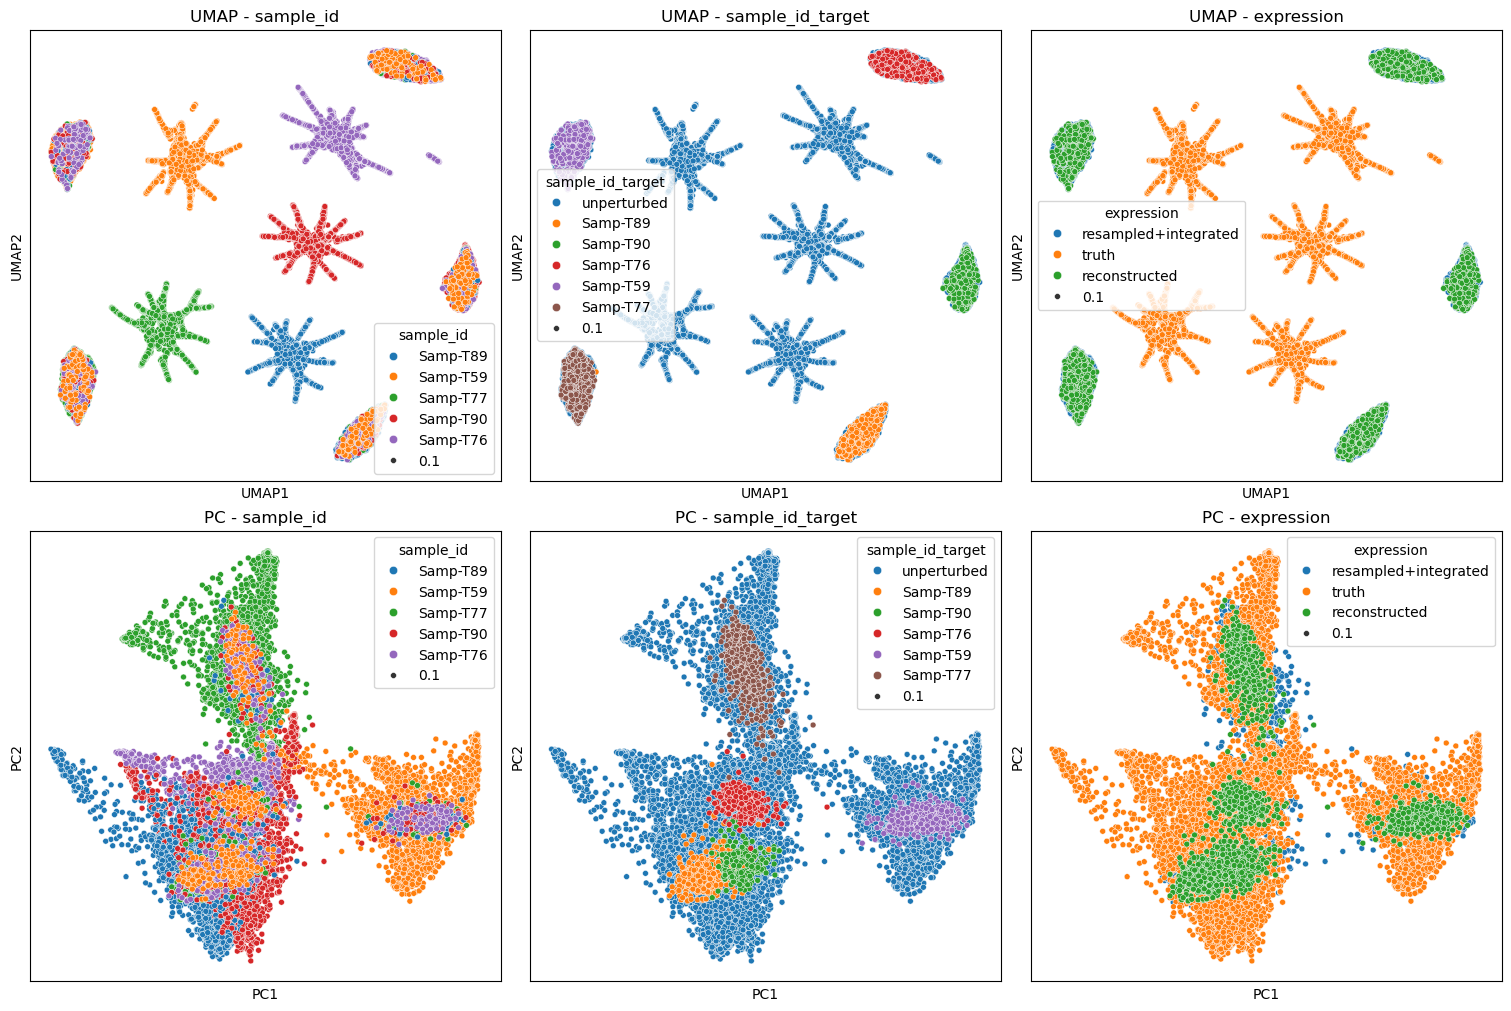

In [24]:
import pandas as pd
_x = np.concatenate(
    [
        x_resamp_int_y.numpy(),
        x_kp,
        x_perturb
    ],
    axis=0
)
_meta = meta_kp.loc[:, [SAMPLE_ID_COL]].copy()
_meta.loc[:, [f'{SAMPLE_ID_COL}_target']] = 'unperturbed'
_meta.loc[:, ['expression']] = 'resampled+integrated'

_meta_truth = _meta.copy()
_meta_truth.loc[:, ['expression']] = 'truth'

meta_perturb.loc[:, ['expression']] = 'reconstructed'

_meta = pd.concat(
    [
        _meta,
        _meta_truth,
        meta_perturb
    ]
)

plot_resampled_latent_space(
    x=_x,
    metadata=_meta,
    color_by=['sample_id', 'sample_id_target', 'expression'],
    use_umap=True,
    show_plot=True
)

In [13]:
# import numpy as np
# import pandas as pd

# def plot_peturbed_latent_space(
#     x_perturb,
#     meta_perturb,
#     x_truth,
#     meta_truth,
#     use_umap=True,
#     show_plot=True
# ):

#     perturb_cols = [
#         col for col in meta_perturb.columns if col in meta_truth.columns
#     ]
#     perturb_col = perturb_cols[0]
#     perturb_target_col = f'{perturb_col}_target'
#     _meta_truth = meta_truth.copy().loc[:, [perturb_col]]
#     _meta_truth.loc[:, [perturb_target_col]] = 'unperturbed'
#     _meta_truth.loc[:, ['expression']] = 'truth'

#     meta_perturb.loc[:, ['expression']] = 'reconstructed'

#     for (source, target), _meta_perturb in meta_perturb.groupby(
#         [perturb_col, perturb_target_col]):

#         _idx = np.union1d(
#             np.where(meta_truth[perturb_col] == source)[0],
#             np.where(meta_truth[perturb_col] == target)[0]
#         )

#         _meta = pd.concat(
#             [
#                 _meta_perturb,
#                 _meta_truth.iloc[_idx,:]
#             ],
#             axis=0
#         )

#         _x = np.concatenate(
#             [
#                 x_perturb[_meta_perturb.index,:],
#                 x_truth[_idx,:]
#             ],
#             axis=0
#         )

#         plot_resampled_latent_space(
#             x=_x,
#             metadata=_meta,
#             color_by=['expression', perturb_col, perturb_target_col],
#             use_umap=use_umap,
#             show_plot=show_plot,
#         )

In [14]:
def plot_peturbed_latent_space(
    x_perturb,
    meta_perturb,
    use_umap=True,
    show_plot=True
):
    perturb_cols = meta_perturb.columns.tolist()
    perturb_col = perturb_cols[0]
    perturb_target_col = f'{perturb_col}_target'

    for source, _meta_perturb in meta_perturb.groupby(
        [perturb_col]):

        plot_resampled_latent_space(
            x=x_perturb[_meta_perturb.index,:],
            metadata=_meta_perturb,
            color_by=[perturb_col, perturb_target_col],
            use_umap=use_umap,
            show_plot=show_plot
        )

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


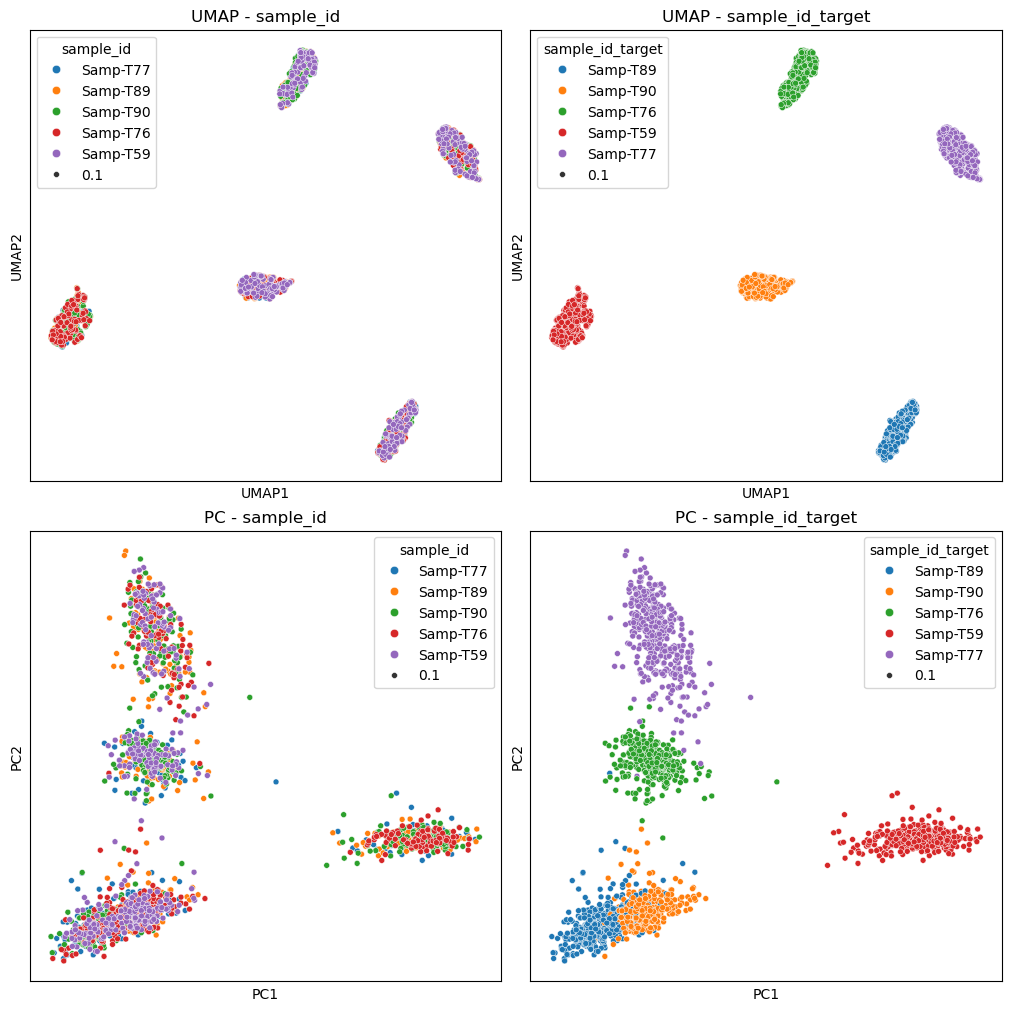

In [15]:
plot_resampled_latent_space(
    x=x_perturb,
    metadata=meta_perturb,
    color_by=['sample_id', 'sample_id_target'],
    use_umap=True,
    show_plot=True
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


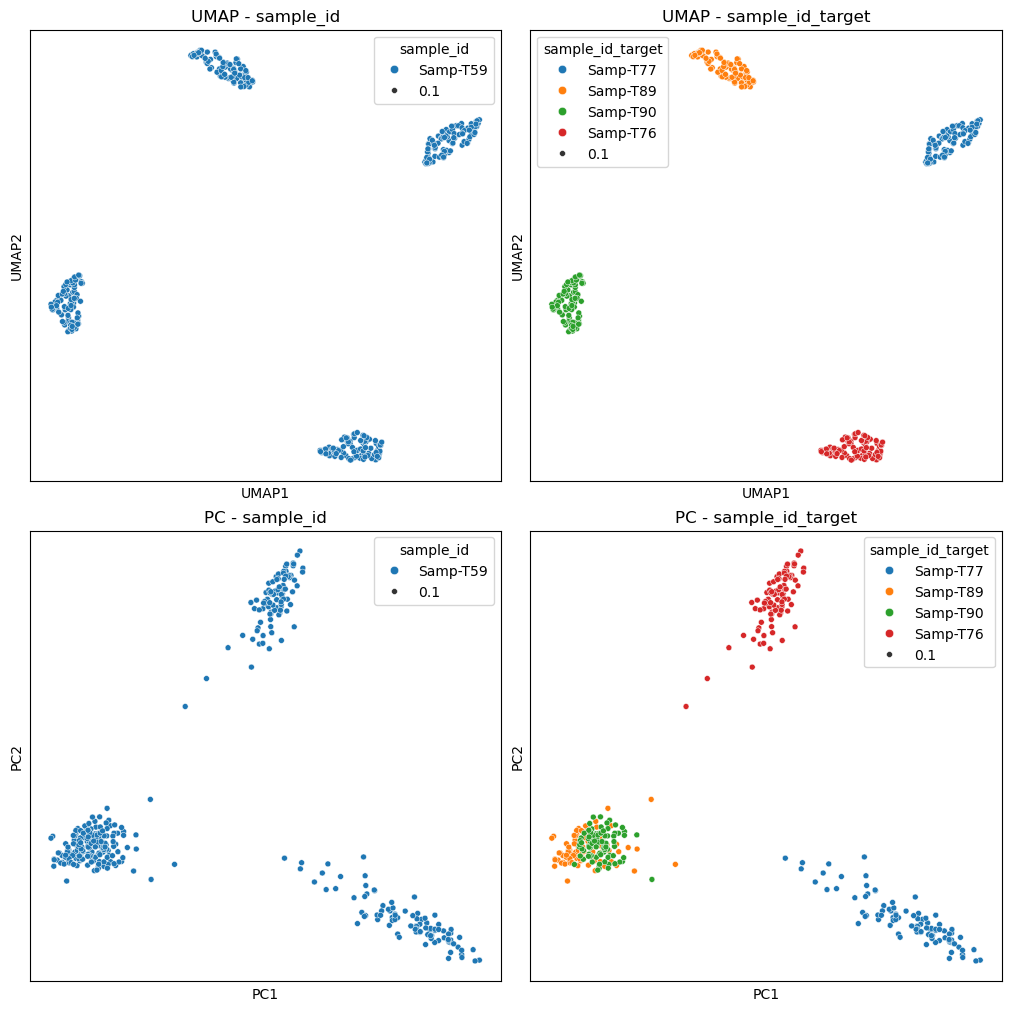

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


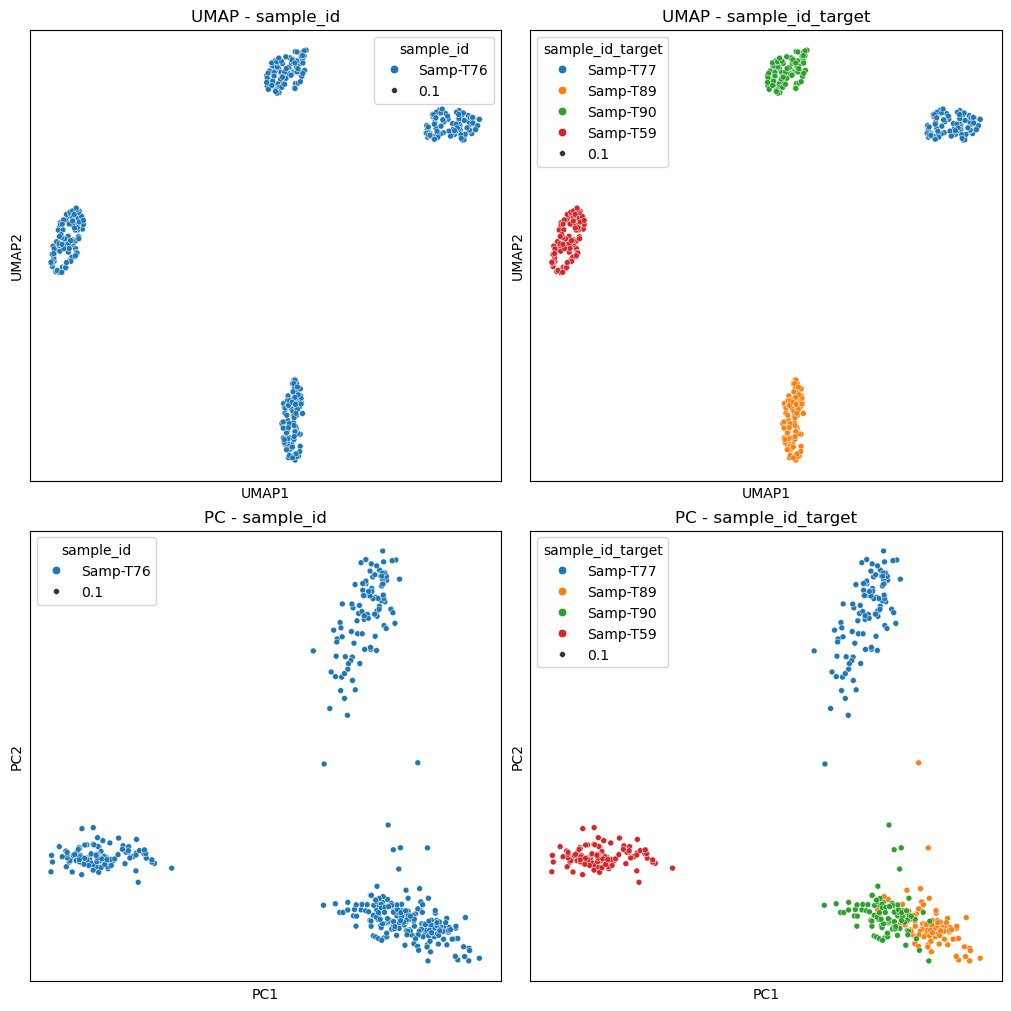

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


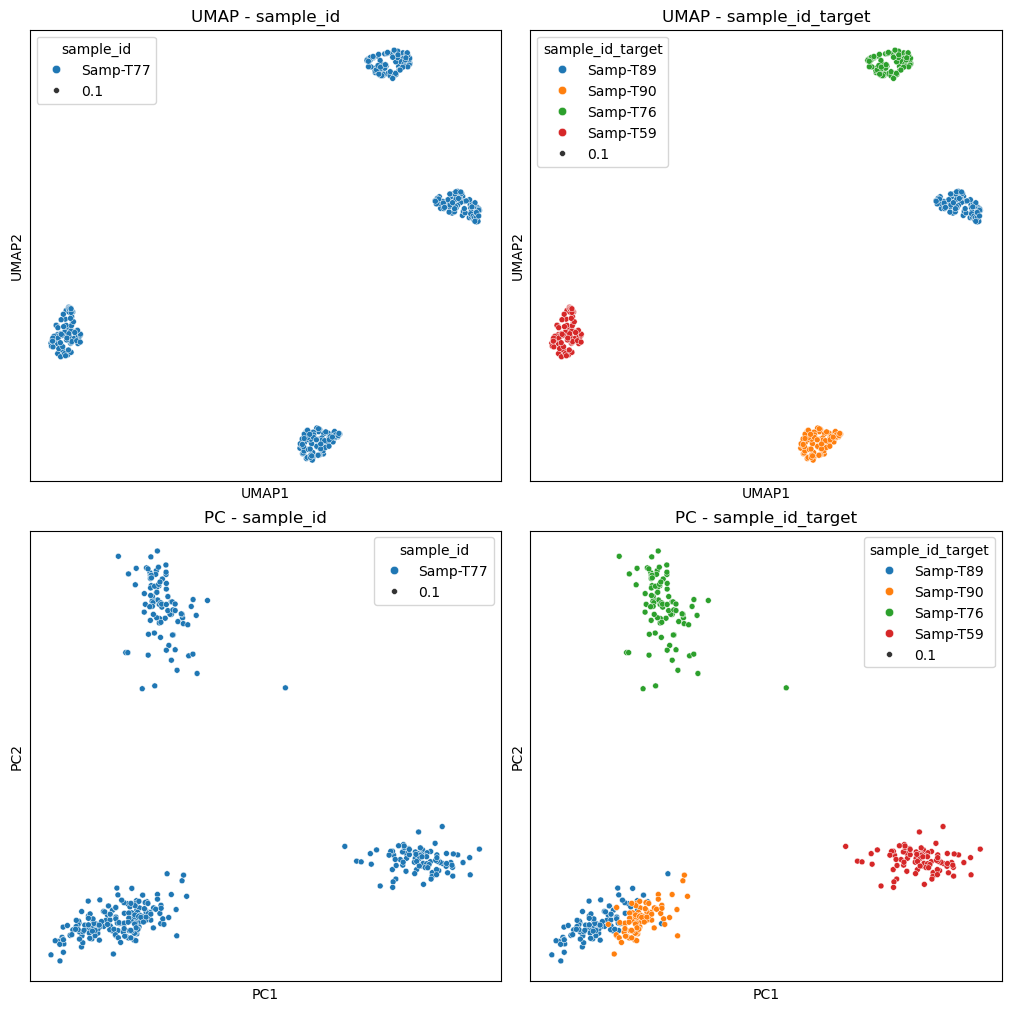

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


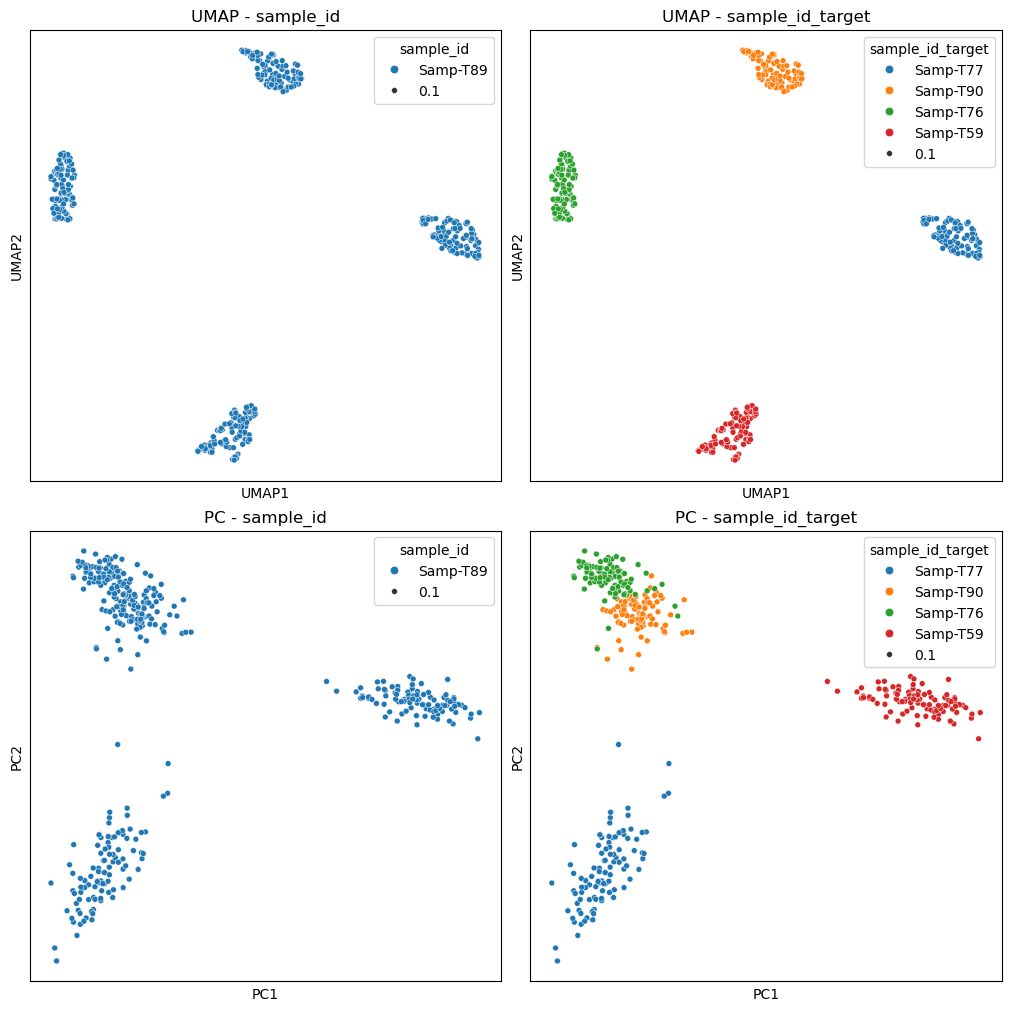

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


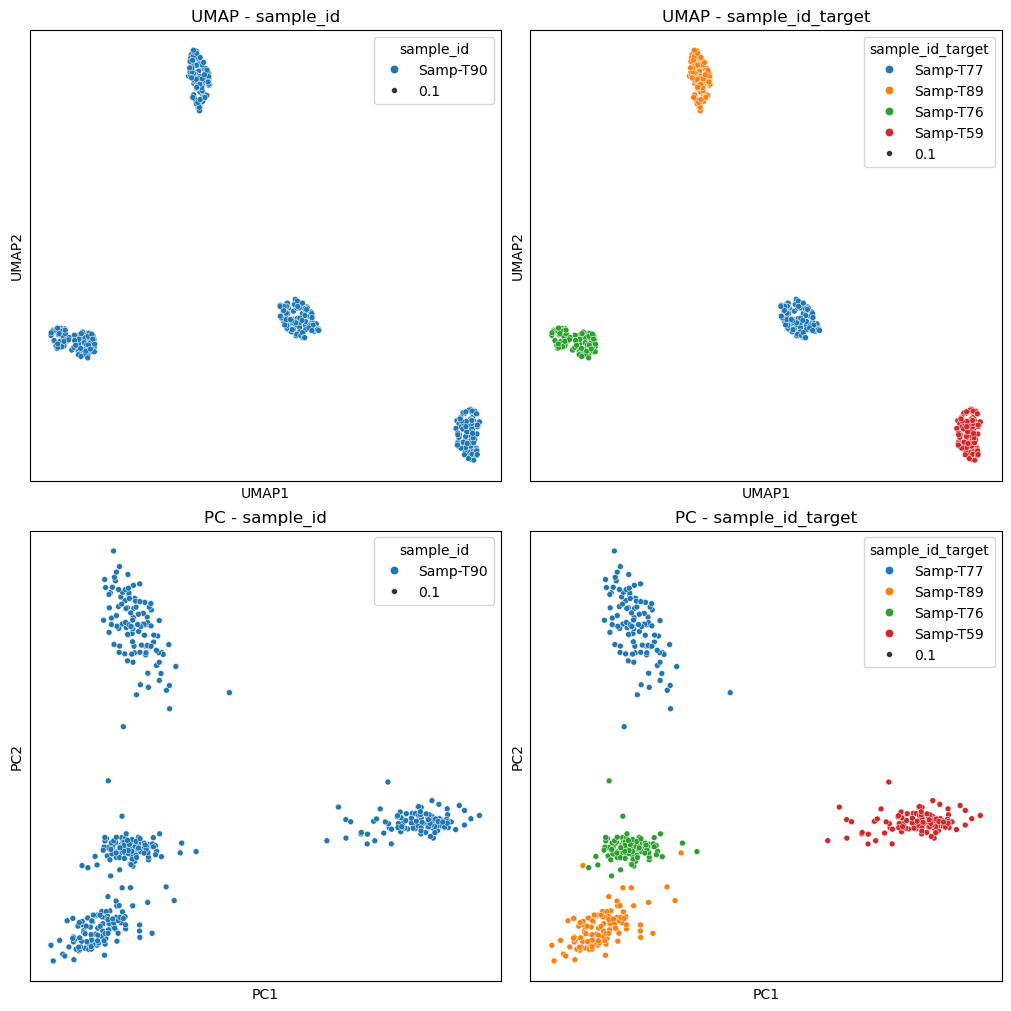

In [16]:
plot_peturbed_latent_space(
    x_perturb,
    meta_perturb,
    use_umap=True,
    show_plot=True
)

In [ ]:
# random_pb_idx = np.where(
#     meta_kp['cell_prop_type'] == 'random'
# )[0]

# plot_peturbed_latent_space(
#     x_perturb,
#     meta_perturb,
#     x_kp[random_pb_idx,:],
#     meta_kp.iloc[random_pb_idx,:],
#     use_umap=True,
#     show_plot=True
# )